In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
plt.style.use(['dark_background'])

from util import experiment
from util import preprocess
import importlib 

import numpy as np
import pandas as pd

from numba import jit, vectorize

import cython
%load_ext cython

In [3]:
importlib.reload(preprocess)
importlib.reload(experiment)


symphony_file = r"C:\Users\zfj\data\021923B\021923B.h5"
# raw_file = r"C:\Users\zfj\data\021923B\n1337_p1241_00007.tif"
# raw_file = r"C:\Users\zfj\data\021923B\n1337_p1241_00008.tif"
raw_file = r"C:\Users\zfj\data\021923B\p1141_p1632_00009.tif"
bin_path =r"C:\Users\zfj\data\021923B\func"

e = experiment.Experiment(symphony_file, raw_file, bin_path)

In [4]:
e.epochs.end_time = e.epochs.start_time + np.uint64((e.epochs.preTime + e.epochs.stimTime + e.epochs.tailTime) * 1e4)
e.epochs = e.epochs.sort_values('start_time')

In [5]:
%%cython -a
import numpy as np
cimport numpy as np


ctypedef np.uint64_t DTYPE_t
cimport cython
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def align_frames_to_epochs(np.ndarray[DTYPE_t, ndim=1] frames, np.ndarray[DTYPE_t, ndim=1] starts, np.ndarray[DTYPE_t, ndim=1] ends):
    '''
    Assumes that all three vectors are in ascending order
    '''
    cdef np.ndarray[np.int64_t, ndim=2] frame_i = np.ones((starts.shape[0],2), dtype=np.int64) * -1

    cdef int i = 0
    cdef int j = 0

    cdef int ne = len(starts)
    cdef int nf = len(frames)

    while frames[i] > starts[j]: # the early frames might occur after the early epochs
        j += 1

    while j < ne:
        while frames[i] < starts[j]:
            i += 1
            if i == nf:
                return frame_i
        frame_i[j,0] = i - 1

        while frames[i] < ends[j]:
            i += 1
            if i == nf:
                return frame_i
        frame_i[j,1] = i - 1
        j += 1
    return frame_i


In [6]:
# %timeit -n100 -r100 align_frames_to_epochs(e.props['time_stamps'], t.iloc[0][0].to_numpy(),t.iloc[0][1].to_numpy())
fi = align_frames_to_epochs(e.props['time_stamps'], e.epochs.start_time.to_numpy(),e.epochs.end_time.to_numpy())
fip = fi[fi>0].reshape((-1,2))


In [7]:
from sklearn.cluster import KMeans
def cluster_trigger_events( begin, end, projector_frame_rate=60.0):
    trigger = e.trigger[begin:end]
    flips = e.flips[np.logical_and(e.flips >= begin, e.flips < end)] - begin

    lv = np.asarray([trigger[flips[i-1]:flips[i]].mean() for i in range(1, len(flips))]).reshape((-1,1))
    
    #ignore the first 10 flips as (possibly) belonging to the start trigger
    km = KMeans(n_clusters=4, algorithm='elkan').fit(lv[10:])
    fl = km.predict(lv)
    idx = np.argsort(km.cluster_centers_.flatten())
    lut = np.zeros_like(idx)
    lut[idx] = np.arange(len(idx))
    fl = [0, *lut[fl]]

    fi = np.empty(len(flips), dtype=int)
    fi[0] = -1

    rm = []
    last_fl = 0
        
    for i in range(1,len(fl)):
        if (flips[i] - flips[i-1] < e.props['pixel_rate']/(projector_frame_rate * 7/3)) or (i<len(fl)-1 and fl[i] == fl[i+1]):
            #false transition: frames cannot come this close together
            rm.append(i) # keep track of this frame to delete later
            continue
        elif fl[i] == 0: # frame is divisible by 4
            fi[i] = ((fi[last_fl] + 4)//4)*4
        elif fl[i] == 3: # frame % 4 == 3
            if not last_fl or (fi[last_fl] == -1 and flips[i] - flips[last_fl] > e.props['pixel_rate']/projector_frame_rate * 5): #either a skip, or the start trigger
                fi[i] = 3 # cannot distinguish the first 4 frames
            else:
                fi[i] = ((fi[last_fl] + 3)//4)*4 + 1
        elif fl[i] == 1: # frame % 4 == 1
            fi[i] = ((fi[last_fl] + 2)//4)*4 + 2
        elif fl[i] == 2: # frame % 4 == 2
            fi[i] = ((fi[last_fl] + 1)//4)*4 + 3
        else:
            print('!')
        
        # last_flip = flips[i]
        last_fl = i    

    flips = np.delete(flips, rm)
    fl = np.delete(fl, rm) # not used?
    fi = np.delete(fi, rm)[1:]

    # dropped = np.where(np.diff(fi)>1)[0]

    trial_i = np.logical_and(fi[:-1]<3, fi[1:]==3)

    dropped_i = np.logical_and(np.diff(fi, prepend=-1) > 1, fi>=0)
    dropped_i = np.logical_and(dropped_i[:-1], ~trial_i)
    dropped = flips[np.argwhere(dropped_i)]

    # #TODO: known issues with dropping:
    # #   - doesn't correctly handle consecutive frame drops ?
    # #   - we frequnetly drop the second-to-last frame ?
    # #   - claims that frames are dropped when there are false triggers


    # trials = flips[np.diff(fi[flips], prepend=-1) < 0]
    trials = flips[np.argwhere(trial_i)]

    if len(dropped):
        print(f"Dropped {len(dropped)} frames in {len(trials)} trials ({len(dropped)/(len(flips) + len(dropped)) * 100:.03f}%)")

    return fi, flips + begin, fl, dropped + begin, trials + begin, km


In [8]:
# tfi, tflips, _, _, ttrials, _ = zip(*[cluster_trigger_events((start-16)*32*128, (end+16)*32*128) for start, end in fip])
e.epochs['flips'] = None
e.epochs['frame_indices'] = None
for i, (start, end) in enumerate(fi):
    if start<0 or end<0:
        continue
    tfi, tflips, *_= cluster_trigger_events((start-16)*32*128, (end+16)*32*128)
    e.epochs.iat[i, e.epochs.columns.get_loc('flips')] = tflips
    e.epochs.iat[i, e.epochs.columns.get_loc('frame_indices')] = tfi

    # plt.plot(tfi)
    

Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 1 frames in 0 trials (0.048%)
Dropped 3 frames in 0 trials (0.142%)
Dropped 1 frames in 0 trials (0.048%)


In [9]:
## this method returns some false positives
# sidx = tflips.argsort()
# idx = np.searchsorted(tflips, e.flips,sorter=sidx)
# idx[idx==len(tflips)] = 0
# missing = e.flips[tflips[sidx[idx]] != e.flips]
found_i = np.any(np.stack([np.logical_and(e.flips >= (start-16)*32*128, e.flips < (end+16)*32*128) for start, end in fip]), axis=0)
missing = e.flips[~found_i]
found =e.flips[found_i]

In [10]:
%%cython -a

import numpy as np
cimport numpy as np

ctypedef np.int64_t DTYPE_t
cimport cython
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def cluster_frames(np.ndarray[DTYPE_t, ndim=1] missing, int separation):
    '''
    Assumes that missing values are in ascending order
    '''
    
    cdef int ne = len(missing)
    cdef np.ndarray[np.uint8_t, ndim=1, cast=True] boundary = np.zeros(ne, dtype=np.bool)

    boundary[0] = True
    boundary[ne-1] = True

    cdef int i = 1
    while i < ne:
        if missing[i] - missing[i-1] > separation:
            boundary[i] = True
            boundary[i-1] = True
        i+=1
    
    return boundary


In [11]:
# %timeit -n100 -r100 cluster_missing_frames(missing, int(e.props['pixel_rate']))
bounds = cluster_frames(missing, int(e.props['pixel_rate']/8))
bounds_f = cluster_frames(found, int(e.props['pixel_rate']/8))

C:\Users\zfj\AppData\Local\Temp\ipykernel_45444\999738502.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bounds = cluster_frames(missing, int(e.props['pixel_rate']/8))
C:\Users\zfj\AppData\Local\Temp\ipykernel_45444\999738502.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bounds_f = cluster_frames(found, int(e.props['pixel_rate']/8))


In [12]:
bounds_i = np.argwhere(bounds).flatten()
bounds_ii = np.asarray([(bounds_i[i-1], bounds_i[i]) for i in range(1,len(bounds_i)) if bounds_i[i] - bounds_i[i-1] > 1])

bounds_fi = np.argwhere(bounds_f).flatten()
bounds_fii = np.asarray([(bounds_fi[i-1], bounds_fi[i]) for i in range(1,len(bounds_fi)) if bounds_fi[i] - bounds_fi[i-1] > 1])


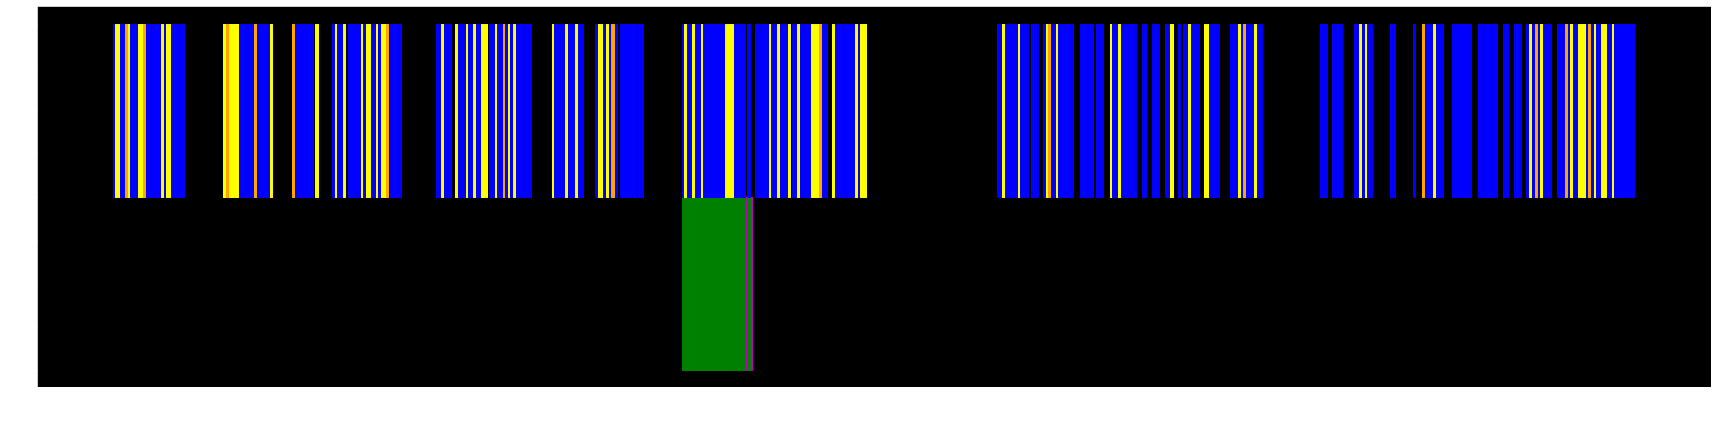

In [13]:
plt.figure(figsize=(30,7))

for start,end in bounds_ii:
    plt.fill_between([e.props['time_stamps'][missing[start]//(32*128)], e.props['time_stamps'][missing[end]//(32*128)]],0,1, color='m')


for start,end in bounds_fii:
    plt.fill_between([e.props['time_stamps'][found[start]//(32*128)], e.props['time_stamps'][found[end]//(32*128)]],0,1, color='g')

# c = ['b','y','o']
for i,epoch in e.epochs.iterrows():
    if epoch.trial_type == b'field':
        ci = 'blue'
    elif epoch.trial_type == b'chirp':
        ci = 'yellow'
    elif epoch.trial_type == b'bars':
        ci = 'orange'
    plt.fill_between([epoch.start_time, epoch.end_time],1,2,color=ci)


In [14]:
bounds_i = np.argwhere(bounds).flatten()
mfi, mflips, _, _, mtrials, mkm = zip(*[cluster_trigger_events(missing[bounds_i[i-1]], missing[bounds_i[i]]) for i in range(1,len(bounds_i)) if bounds_i[i] - bounds_i[i-1] > 1])


Dropped 1 frames in 0 trials (0.048%)


In [15]:
#now let's add some trials to e.epochs with nan entries except for the start_time?
#i also want to make some kind of map from the epochs to the flip/frame indices...

ttrials = mtrials

ls = (np.asarray(ttrials).flatten()//128) % 32
ts = e.props['time_stamps'][np.asarray(ttrials).flatten()//(32*128)] - (1e7/e.props['line_rate'] * (32 - ls)).astype(np.int64)# + (1e7/e.props['pixel_rate'] * (np.asarray(ttrials).flatten() % 128)).astype(np.int64) # bidi?
ts[ls % 2 == 0] -= (1e7/e.props['pixel_rate'] * (128 - np.asarray(ttrials).flatten()[ls % 2 == 0] % 128)).astype(np.int64)
ts[ls % 2 == 1] -= (1e7/e.props['pixel_rate'] * (np.asarray(ttrials).flatten()[ls % 2 == 1] % 128)).astype(np.int64)
d = ts[:,None] - e.epochs.start_time.to_numpy().astype(np.int64)[None,:]
di = np.argmin(np.abs(d), axis=1)

np.median([d[i,di[i]] for i in range(len(di))])


ls = (np.concatenate(mtrials)//128) % 32
ts = e.props['time_stamps'][np.concatenate(mtrials)//(32*128)] - (1e7/e.props['line_rate'] * (32 - ls)).astype(np.int64)# + (1e7/e.props['pixel_rate'] * (np.asarray(ttrials).flatten() % 128)).astype(np.int64) # bidi?
ts[ls % 2 == 0] -= (1e7/e.props['pixel_rate'] * (128 - np.concatenate(mtrials)[ls % 2 == 0] % 128)).astype(np.int64)
ts[ls % 2 == 1] -= (1e7/e.props['pixel_rate'] * (np.concatenate(mtrials)[ls % 2 == 1] % 128)).astype(np.int64)


C:\Users\zfj\AppData\Local\Temp\ipykernel_45444\3576918201.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ls = (np.asarray(ttrials).flatten()//128) % 32
C:\Users\zfj\AppData\Local\Temp\ipykernel_45444\3576918201.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ts = e.props['time_stamps'][np.asarray(ttrials).flatten()//(32*128)] - (1e7/e.props['line_rate'] * (32 - ls)).astype(np.int64)# + (1e7/e.props['pixel_rate'] * (np.asarray(ttrials).flatten() % 128)).astype(np.int64) # bidi?


IndexError: arrays used as indices must be of integer (or boolean) type

In [16]:
# can't really add new rows to the df correctly because of the data types
#start time, end time, and bools are the issues
#just have to do this manually when they come up, I guess, though we can still look for them
for c,d in e.epochs.dtypes.items():
    print(c, '\t\t',str(d))

start_time 		 uint64
trial_type 		 object
cx 		 object
cy 		 object
theta 		 object
MstarIntensityBar 		 float64
MstarIntensityChirp 		 float64
MstarIntensitySpot 		 float64
MstarMean 		 float64
NDF 		 float64
RstarIntensityBar 		 float64
RstarIntensityChirp 		 float64
RstarIntensitySpot 		 float64
RstarMean 		 float64
SstarIntensityBar 		 float64
SstarIntensityChirp 		 float64
SstarIntensitySpot 		 float64
SstarMean 		 float64
antialias 		 uint8
barIntensity 		 float64
barLED 		 float64
barLength 		 float64
barWidth 		 float64
bitDepth 		 float64
chan1 		 object
chan1Hold 		 float64
chan1Mode 		 object
chirpIntensity 		 float64
chirpLED 		 float64
chirpSize 		 float64
colorPattern1 		 object
colorPattern2 		 object
colorPattern3 		 object
extentX 		 float64
extentY 		 float64
forcePrerender 		 object
frameRate 		 float64
imaging 		 uint8
meanLevel 		 float64
numberOfBars 		 float64
numberOfChirps 		 float64
numberOfFields 		 float64
numberOfPatterns 		 float64
offsetX 		 float64
offse

In [17]:
def time_events(epochs):
    cols = {
        'pre_on': int, 'stim_on': int, 'stim_off': int, 'tail_off': int,
        'pre_on_i': int, 'stim_on_i': int, 'stim_off_i': int, 'tail_off_i': int, 
        'epoch_id': int
        }
    scols = {**cols, 'cx':np.float64, 'cy':np.float64}
    spots = pd.DataFrame(columns=scols.keys()).astype(scols, copy=False, errors='ignore')
    bcols = {**cols, 'theta':np.float64}
    bars = pd.DataFrame(columns=bcols.keys()).astype(bcols, copy=False, errors='ignore')
    chirps = pd.DataFrame(columns=cols.keys()).astype(cols, copy=False, errors='ignore')

    for i,epoch in epochs.iterrows():
        flips = epoch.flips
        if flips is None:
            continue
        fi = epoch.frame_indices

        # flip_i =np.where(flips==tr)[0][0] # hmmm...
        # flip_i = flips[0]
        # flip_i = 0

        if epoch.trial_type==b'field':
            spot_trial = int(epoch[['spotPreFrames','spotStimFrames','spotTailFrames']].sum())
            spots_per_epoch = 35*60//spot_trial

            spots_t = pd.DataFrame(np.zeros((spots_per_epoch,len(scols))), columns=scols).astype(scols, copy=False, errors='ignore')
            spots_t.epoch_id = i
            pre_i = 0
            on_i = int(epoch.spotPreFrames)
            off_i = int(epoch.spotStimFrames + on_i)
            tail_i = spot_trial
            j = 0
            k = 0

            while j < spots_per_epoch:#k < len(flips):#, flip in enumerate(flips):
                # associate the timing events with the first frame flip that exceeds the requisite frame count
                # specifically, the timing of the named events for each trial will be linked with a linear index into the movie

                #pre_on, pre_on_i
                pre_on = np.argwhere(fi[k:]>=pre_i)[0,0]
                spots_t.iat[j, 0] = flips[k + pre_on]
                spots_t.iat[j, 4] = fi[k + pre_on]
                
                #stim_on, stim_on_i
                stim_on = np.argwhere(fi[k:]>=on_i)[0,0]
                spots_t.iat[j, 1] = flips[k + stim_on]
                spots_t.iat[j, 5] = fi[k + stim_on]

                #stim_off, stim_off_i
                stim_off = np.argwhere(fi[k:]>=off_i)[0,0]
                spots_t.iat[j, 2] = flips[k + stim_off]
                spots_t.iat[j, 6] = fi[k + stim_off - 1]

                tail_off = np.argwhere(fi[k:]>=tail_i)
                if len(tail_off):
                    tail_off = tail_off[0,0]
                else: #we're missing the last flip
                    tail_off = len(flips) - k - 1
                
                spots_t.iat[j, 3] = flips[k + tail_off]
                spots_t.iat[j, 7] = fi[k + tail_off - 1]
                

                spots_t.iat[j, 9] = epoch.cx[j]
                spots_t.iat[j, 10] = epoch.cy[j]


                #increment the trial counter
                k = tail_i
                pre_i += spot_trial
                on_i += spot_trial
                off_i += spot_trial
                tail_i += spot_trial
            
                j+=1
            
            spots = pd.concat([spots, spots_t])
                
        elif epoch.trial_type==b'chirp':
            chirps_t = pd.DataFrame(np.zeros((1,len(cols))), columns=cols).astype(cols, copy=False, errors='ignore')
            chirps_t.epoch_id = i
            
            chirps_t.pre_on= flips[0]
            chirps_t.pre_on_i= fi[0]

            stim_on = np.argwhere(fi>=60*2)[0,0] #TODO: should be frame rate
            chirps_t.stim_on = flips[stim_on]
            chirps_t.stim_on_i = fi[stim_on]

            stim_off = np.argwhere(fi>=60*30)[0,0]
            chirps_t.stim_off = flips[stim_off]
            chirps_t.stim_off_i = fi[stim_off - 1]
            
            tail_off = np.argwhere(fi>=60*35)
            if len(tail_off):
                tail_off = tail_off[0,0]
            else:
                tail_off = len(flips) - 1
            
            chirps_t.tail_off = flips[tail_off]
            chirps_t.tail_off_i = fi[tail_off - 1]

            
            chirps = pd.concat([chirps, chirps_t])

        elif epoch.trial_type==b'bars':            
            bars_t = pd.DataFrame(np.zeros((10,len(bcols))), columns=bcols).astype(bcols, copy=False, errors='ignore')
            bars_t.epoch_id = i            
            
            pre_i = 0
            on_i = 15
            off_i = 195
            tail_i = 210
            j = 0
            k = 0

            while j < 10:#k < len(flips):#, flip in enumerate(flips):
                # associate the timing events with the first frame flip that exceeds the requisite frame count
                # specifically, the timing of the named events for each trial will be linked with a linear index into the movie

                #pre_on, pre_on_i
                pre_on = np.argwhere(fi[k:]>=pre_i)[0,0]
                bars_t.iat[j, 0] = flips[k + pre_on]
                bars_t.iat[j, 4] = fi[k + pre_on]
                
                #stim_on, stim_on_i
                stim_on = np.argwhere(fi[k:]>=on_i)[0,0]
                bars_t.iat[j, 1] = flips[k + stim_on]
                bars_t.iat[j, 5] = fi[k + stim_on]

                #stim_off, stim_off_i
                stim_off = np.argwhere(fi[k:]>=off_i)[0,0]
                bars_t.iat[j, 2] = flips[k + stim_off]
                bars_t.iat[j, 6] = fi[k + stim_off - 1]

                tail_off = np.argwhere(fi[k:]>=tail_i)
                if len(tail_off):
                    tail_off = tail_off[0,0]
                else: #we're missing the last flip
                    tail_off = len(flips) - k - 1
                
                bars_t.iat[j, 3] = flips[k + tail_off]
                bars_t.iat[j, 7] = fi[k + tail_off - 1]
                

                bars_t.iat[j, 9] = epoch.theta[j]


                #increment the trial counter
                k = tail_i
                pre_i += 210
                on_i += 210
                off_i += 210
                tail_i += 210
            
                j+=1
            
            bars = pd.concat([bars, bars_t])
    return spots, chirps, bars

In [18]:
trials = [epoch.flips[0] for _,epoch in e.epochs.iterrows() if epoch.flips is not None]

spots, chirps, bars = time_events(e.epochs)

In [21]:
import suite2p
tif = suite2p.io.tiff.ScanImageTiffReader(raw_file)

In [22]:
func = tif.data().reshape((-1,4,32,128))[:,1,:,:]

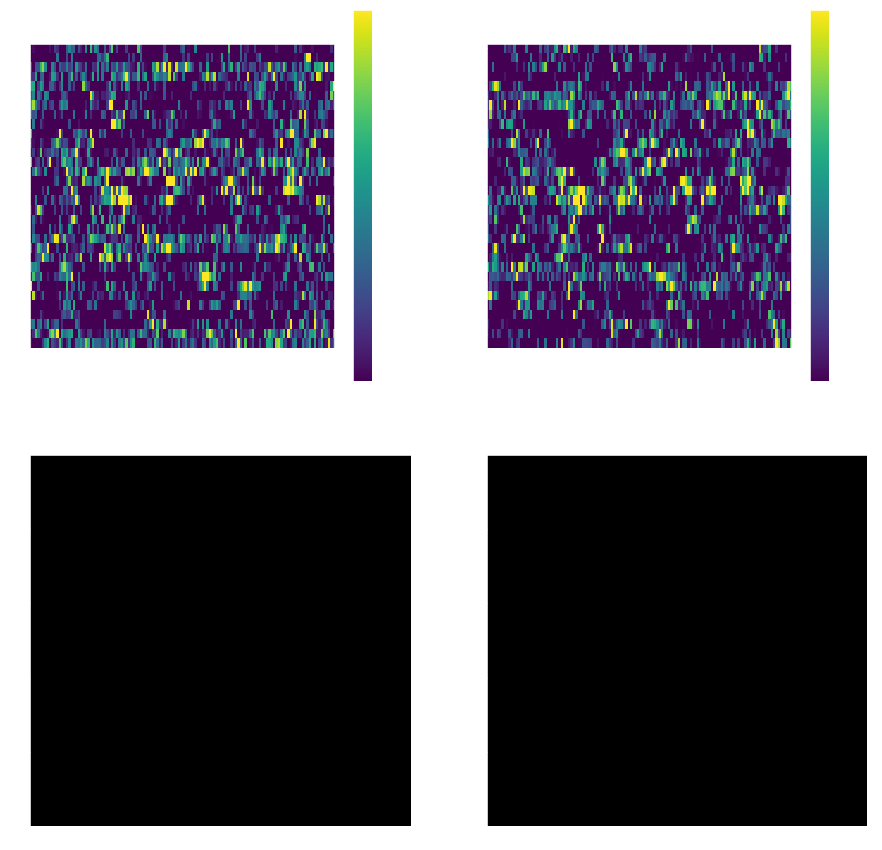

In [52]:
_,axs = plt.subplots(2,2, figsize=(15,15))

plt.sca(axs[0][0])
plt.imshow(func[chirps.stim_on.to_numpy()[1] // (32*128) + 1], aspect=4, interpolation='none')
plt.clim(0,1000)
plt.colorbar()

plt.sca(axs[0][1])
plt.imshow(func[chirps.stim_on.to_numpy()[1] // (32*128) + 2], aspect=4, interpolation='none')
plt.clim(0,1000)
plt.colorbar()

# plt.sca(axs[1][0])
# plt.imshow(func[bars.stim_on.to_numpy()[0] // (32*128) + 151], aspect=4, interpolation='none')
# plt.clim(0,1000)
# plt.colorbar()

# plt.sca(axs[1][1])
# plt.imshow(func[bars.stim_on.to_numpy()[0] // (32*128) + 152], aspect=4, interpolation='none')
# plt.clim(0,1000)
# plt.colorbar()

In [24]:
class intervals:
    def __init__(self, array):
        self.i = 0
        self.N = len(array)
        self.array = array
    def __iter__(self):
        return self
    def __next__(self):
        self.i += 1
        if self.i < self.N:
            return self.array[self.i-1], self.array[self.i]
        raise StopIteration

In [137]:
row.frame_indices.shape, row.flips.shape
row

pre_on                                                   103971434
stim_on                                                  104240719
stim_off                                                 108011260
tail_off                                                 108682295
pre_on_i                                                         3
                                       ...                        
tailTime                                                       0.0
LED                                                           50.0
end_time                                        638124218177344462
flips            [103971434, 103980426, 103982614, 103984929, 1...
frame_indices    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
Name: 0, Length: 73, dtype: object

In [140]:
def chirp_pattern(intensity, sf = 60):
   sf = int(sf)
   chirp = np.concatenate((
        np.zeros(2*sf), #pre time
        np.ones(3*sf), #positive step
        np.zeros(3*sf), #negative time
        np.ones(2*sf) * 0.5, #inter time
        
        -np.sin(2*np.pi*np.linspace(0,8/sf,sf*8).cumsum() + np.pi)/2 + .5, # freq chirp

        np.ones(2*sf) * 0.5, #inter time
        -np.linspace(0,1,sf*8)*np.sin(2*np.pi*2*np.arange(1/sf, 8+(1/sf), 1/sf) + np.pi)/2 + .5, # amp chirp
      

        np.ones(2*sf) * 0.5, #inter time
        np.zeros(5*sf), #tail time
   )) 

   return np.round(chirp * 255 * intensity).astype(np.uint8)#.astype(float) / (255 * intensity)
#    return (chirp * 255 * intensity).astype(np.uint8)#.astype(float) / (255 * intensity)

In [357]:
tmp = pd.concat((chirps,bars,spots), ignore_index=True, join='inner').join(e.epochs, on='epoch_id')
tmp

pre_on    stim_on   stim_off   tail_off  pre_on_i  stim_on_i  \
0      7992571    8261870   12032395   12703434         3        120   
1     24795905   25065206   28835738   29506778         3        120   
2     41711400   41980684   45751234   46422266         3        120   
3     92624041   92893326   96663877   97334907         3        120   
4     98273040   98542330  102312876  102983917         3        120   
..         ...        ...        ...        ...       ...        ...   
505  143350480  143377357  143411054  143512000      1728       1740   
506  143518819  143545697  143579386  143680339      1803       1815   
507  143687159  143714037  143747716  143848679      1878       1890   
508  143855483  143882364  143916056  144017017      1953       1965   
509  144023693  144050698  144084395  144183162      2028       2040   

     stim_off_i  tail_off_i  epoch_id          start_time  ... spotSize  \
0          1799        2098       163  638124210700890244  ...     30.0   
1          1799        2098       156  638124211948544953  ...     30.0   
2          1799        2098       151  638124213204520336  ...     30.0   
3          1799        2098       165  638124216984801077  ...     30.0   
4          1799        2098       164  638124217404234422  ...     30.0   
..          ...         ...       ...                 ...  ...      ...   
505        1754        1799       169  638124220463285534  ...     30.0   
506        1829        1874       169  638124220463285534  ...     30.0   
507        1904        1949       169  638124220463285534  ...     30.0   
508        1979        2024       169  638124220463285534  ...     30.0   
509        2054        2098       169  638124220463285534  ...     30.0   

    spotStimFrames spotTailFrames stimTime  stimTimeRecord  tailTime    LED  \
0             15.0           45.0  35000.0               1       0.0   50.0   
1             15.0           45.0  35000.0               1       0.0   50.0   
2             15.0           45.0  35000.0               1       0.0   50.0   
3             15.0           45.0  35000.0               1       0.0   50.0   
4             15.0           45.0  35000.0               1       0.0   50.0   
..             ...            ...      ...             ...       ...    ...   
505           15.0           45.0  35000.0               1       0.0  200.0   
506           15.0           45.0  35000.0               1       0.0  200.0   
507           15.0           45.0  35000.0               1       0.0  200.0   
508           15.0           45.0  35000.0               1       0.0  200.0   
509           15.0           45.0  35000.0               1       0.0  200.0   

               end_time                                              flips  \
0    638124211050890244  [7992571, 8001577, 8003765, 8006080, 8008268, ...   
1    638124212298544953  [24795905, 24804912, 24807100, 24809415, 24811...   
2    638124213554520336  [41711400, 41720407, 41722595, 41724910, 41727...   
3    638124217334801077  [92624041, 92633048, 92635236, 92637551, 92639...   
4    638124217754234422  [98273040, 98282047, 98284235, 98286551, 98288...   
..                  ...                                                ...   
505  638124220813285534  [139472292, 139481173, 139483486, 139485675, 1...   
506  638124220813285534  [139472292, 139481173, 139483486, 139485675, 1...   
507  638124220813285534  [139472292, 139481173, 139483486, 139485675, 1...   
508  638124220813285534  [139472292, 139481173, 139483486, 139485675, 1...   
509  638124220813285534  [139472292, 139481173, 139483486, 139485675, 1...   

                                         frame_indices  
0    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...  
1    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...  
2    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...  
3    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...  
4    [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...  
..            

In [366]:

# ffunc = func.copy().astype(np.double)
# ffunc[:,1::2,:] = np.flip(ffunc[:,1::2,:], axis=2)
# ffunc = ffunc.flatten()


# F,Y,X = func.shape
# tt = np.zeros((F,Y,X))
# tt += np.arange(0, X)[None, None, :] / e.props['pixel_rate']
# tt += np.arange(0, Y)[None, :, None] / e.props['line_rate']
# tt += ((e.props['time_stamps'] - e.props['time_stamps'][0]) / 1e7)[:, None, None]
# tt = tt.flatten()

# lookup = np.load('artifact_lut.npy')

# pat = np.empty((2098, len(tmp)))
# spat = np.zeros((2098, len(tmp), 256))
# spat2 = np.zeros_like(spat)
# npat = np.zeros_like(spat)
lasta = np.nan



for j in range(454,len(tmp)):
    print(j)
    row = tmp.iloc[j]
    if row.trial_type==b'chirp':
        pattern = chirp_pattern(row.chirpIntensity * 2, row.frameRate)
        pattern = pattern[row.frame_indices]
    elif row.trial_type==b'field':
        pattern = np.zeros(len(row.frame_indices), dtype=np.uint8)
        pattern[np.logical_and(row.frame_indices >= row.spotPreFrames, row.frame_indices < (row.spotPreFrames + row.spotStimFrames))] = row.spotIntensity
    elif row.trial_type==b'bars':
        pattern = np.zeros(len(row.frame_indices), dtype=np.uint8)
        pattern[np.logical_and(row.frame_indices >= 15, row.frame_indices < 195)] = row.barIntensity
    else:
        raise Exception('whoops')


    for i,((a,b),fi) in enumerate(zip(intervals(row['flips']), row['frame_indices'])):
        if i>=2098:
            break
        
        if (not (a - 1) % e.props['frame_shape'][1]) or (not (b - 1) % e.props['frame_shape'][1]):
            spat[i,j,ind] = np.nan # shouldn't need to do anything... 0/0 is nan
            spat2[i,j,ind] = np.nan # shouldn't need to do anything... 0/0 is nan
            npat[i,j,ind] = np.nan
            # pat[i,j] = np.nan

            ffunc[a:b] = np.nan
            print('.',end='')
            lasta = a
            continue

        # pat[i,j] = ffunc[a:b].mean()

        # lu = lookup[pattern][fi].astype(float)
        lu = lookup[pattern][i].astype(float)
        lu[lu==0] = np.nan
        
        inds = ((tt[a:b] - tt[a]) / (tt[b] - tt[a]) * 256).astype(int)
        for ind,ab in zip(inds, np.arange(a,b)):
            f = ffunc[ab]
            spat[i,j,ind] += f
            npat[i,j,ind] += 1
            ffunc[ab] *= lu[ind]

        if npat[i,j,1] == 0 and npat[i,j,8] == 0:
            print('!', end='')
            spat[i,j,:] = np.nan
            npat[i,j,:] = np.nan

            spat[i-1,j,:] = np.nan
            npat[i-1,j,:] = np.nan

            ffunc[a:b] = np.nan
            ffunc[lasta:a] = np.nan

        # nmask = (lookup[pattern[:2098]]).astype(float)
        # nmask[nmask==0] = np.nan
        spat2[i,j,:] = spat[i,j,:]
        spat2[i,j,:] *= lu
        lasta = a

spat /= npat
spat2 /= npat


454
..............455
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..!!!!!!!..!!!!!..!!!!!!!!!!!!..456
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..!!!!!!!..!!!!!..!!!!!!!!!!!!..457
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..!!!!!!!..!!!!!..!!!!!!!!!!!!..458
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..!!!!!!!..!!!!!..!!!!!!!!!!!!..459
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..!!!!!!!..!!!!!..!!!!!!!!!!!!..460
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..!!!!!!!..!!!!!..!!!!!!!!!!!!..461
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..!!!!!!!..!!!!!..!!!!!!!!!!!!..462
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..!!!!!!!..!!!!!..!!!!!!!!!!!!..463
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..!!!!!!!..!!!!!..!!!!!!!!!!!!..464
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..!!!!!!!..!!!!!..!!!!!!!!!!!!..465
!!!!!!!!!!!!!..!!!!!!!!!!!!!!..!!!!!!!!!!!!!!!!!..!!!!!!..

C:\Users\zfj\AppData\Local\Temp\ipykernel_45444\2007406207.py:84: RuntimeWarning: invalid value encountered in true_divide
  spat /= npat
C:\Users\zfj\AppData\Local\Temp\ipykernel_45444\2007406207.py:85: RuntimeWarning: invalid value encountered in true_divide
  spat2 /= npat


In [364]:
pattern.shape, spat.shape, pat.shape

((2113,), (2098, 510, 256), (2098, 510))

In [371]:
ffunc = ffunc.reshape((-1, *e.props['frame_shape']))
ffunc[:,1::2,:] = np.flip(ffunc[:,1::2,:], axis=2)



In [372]:
ifunc = ffunc.copy()
ianat = tif.data().reshape((-1,4,32,128))[:,0,:,:].copy().astype(np.double)
from scipy.interpolate import interp1d

for i in range(e.props['frame_shape'][0]):
    for j in range(e.props['frame_shape'][1]):
        n = np.isnan(ifunc[:,i,j])
        ifunc[n,i,j] = interp1d(np.nonzero(~n)[0], ifunc[~n,i,j], fill_value='extrapolate')(np.nonzero(n)[0])
        ianat[n,i,j] = interp1d(np.nonzero(~n)[0], ianat[~n,i,j], fill_value='extrapolate')(np.nonzero(n)[0])
        

In [388]:
import os

# if not os.path.exists(os.path.join(bin_path, 'functional.bin')):
# func = suite2p.io.BinaryRWFile(Lx=e.props['frame_shape'][1], Ly=e.props['frame_shape'][0], filename=os.path.join(bin_path, 'p1141_p1632_00009_functional.bin'))
# func.write(ffunc)

os.mkdir(os.path.join(bin_path, 'p1141_p1632_00009'))

anat = suite2p.io.BinaryRWFile(Lx=e.props['frame_shape'][1], Ly=e.props['frame_shape'][0], filename=os.path.join(bin_path, 'p1141_p1632_00009','anatomy.bin'))
anat.write(ianat)

np.save(os.path.join(bin_path, 'p1141_p1632_00009', 'functional.npy'), ffunc)



In [394]:
# do reg?
from util import register

importlib.reload(register)

reg = register.register(
    # os.path.join(bin_path, 'p1141_p1632_00009_anatomy.bin'),
    raw_file,
    r"C:\Users\zfj\data\021923B\p1141_p1632_stack_00001.tif",
    bin_path,
    e.props,
)



  3%|▎         | 3/88 [12:22<5:37:36, 238.32s/it]

In [337]:
# ffunc
# fi = 47
# plt.imshow(ffunc[tmp.iloc[0].flips[0] // (32*128) + fi], aspect=4, interpolation='none')
d = ifunc[tmp.iloc[0].flips[0] // (32*128) : tmp.iloc[0].flips[-1] // (32*128)].copy()

# plt.plot(np.nanmean(d[:,15:17,30:40], axis=(1,2)))

# from sklearn.decomposition import PCA #MiniBatchSparsePCA as PCA # SparsePCA as PCA
# from sklearn.decomposition import MiniBatchSparsePCA as PCA # SparsePCA as PCA
from sklearn.decomposition import SparsePCA as PCA


d = d.reshape((-1, 32*128))
d = d - d.mean(axis=0)
d = d / d.std(axis=0)


# pca = PCA(n_components=100)#, n_jobs=8, alpha=5, batch_size=20)
# pca = PCA(n_components=100, n_jobs=8, alpha=6, batch_size=20)
pca = PCA(n_components=100, n_jobs=8, alpha=6,)
pcs = pca.fit_transform(d.T)
print(pcs.shape, pca.components_.shape)


(4096, 100) (100, 1150)


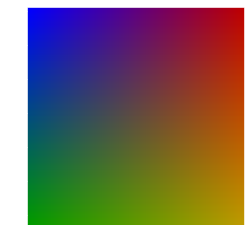

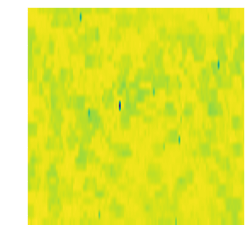

In [315]:
r = np.tile(np.linspace(0,0.75,128)[None,:],( 32,1)).flatten()
g = np.tile(np.linspace(0,0.6, 32)[:,None],(1,128)).flatten()
b = (np.flip(np.linspace(0,1.0,32))[:,None] * np.flip(np.linspace(0,1.0,128))[None,:]).flatten()

c = np.stack((r,g,b), axis=1)

plt.imshow(c.reshape((32,128,3)), aspect=4)
plt.show()

plt.imshow(d.reshape((-1,32,128)).min(axis=0), aspect=4)

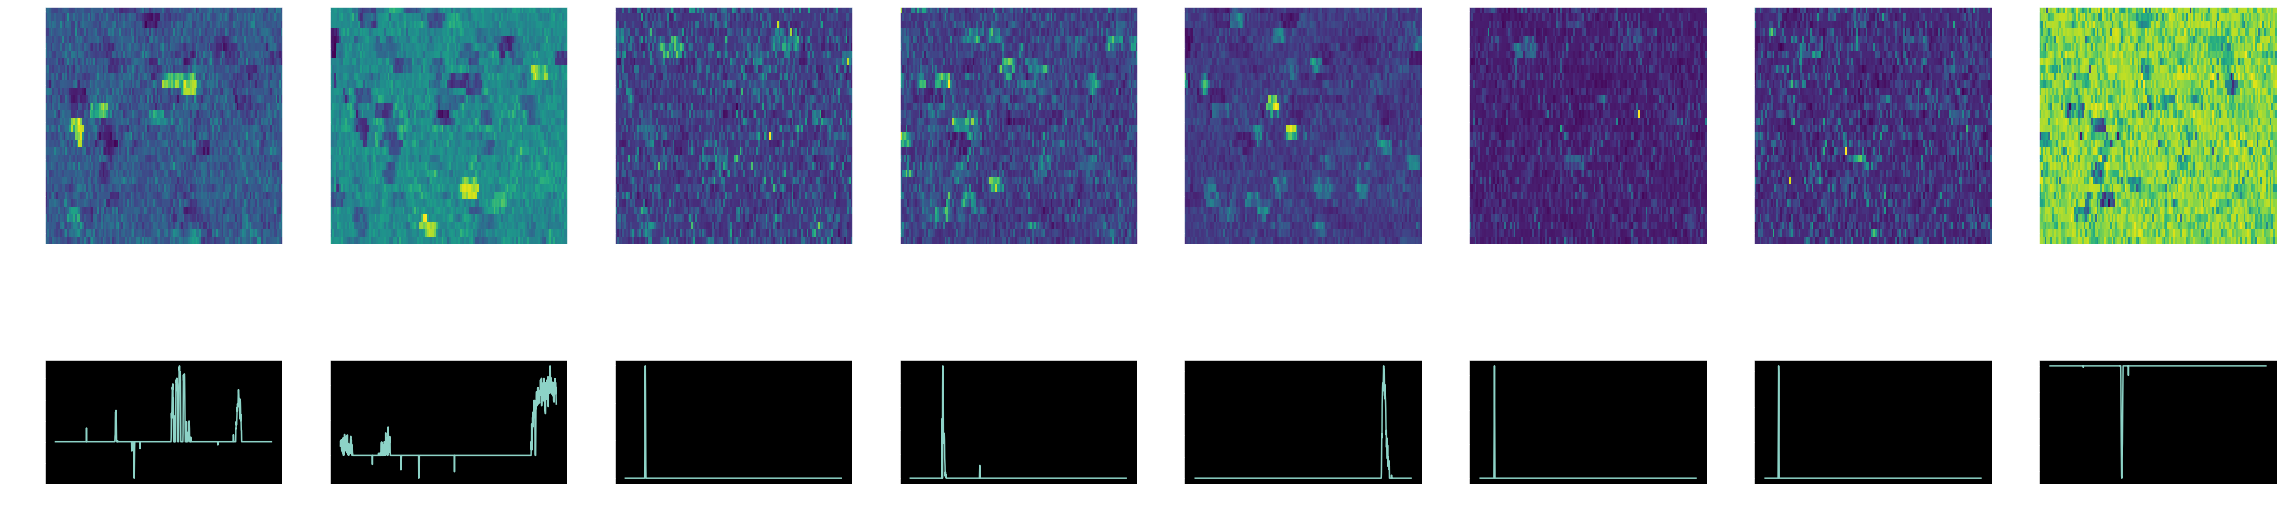

In [338]:
_,axs = plt.subplots(2,8,figsize=(40,10), gridspec_kw={'height_ratios':[3,1]})

for cmp in range(8):
    # if pcs[np.argmax(np.abs(pcs[:,cmp])),cmp] < 0:
    #     sign = -1
    # else:
    #     sign = 1

    # axs[0,cmp].imshow(sign * pca.components_[cmp].reshape(32,128), aspect=4, interpolation = 'none')
    # axs[1,cmp].plot(sign * pcs[:,cmp])
    axs[0,cmp].imshow(pcs[:,cmp].reshape(32,128), aspect=4, interpolation = 'none')
    axs[1,cmp].plot(pca.components_[cmp,:])
    


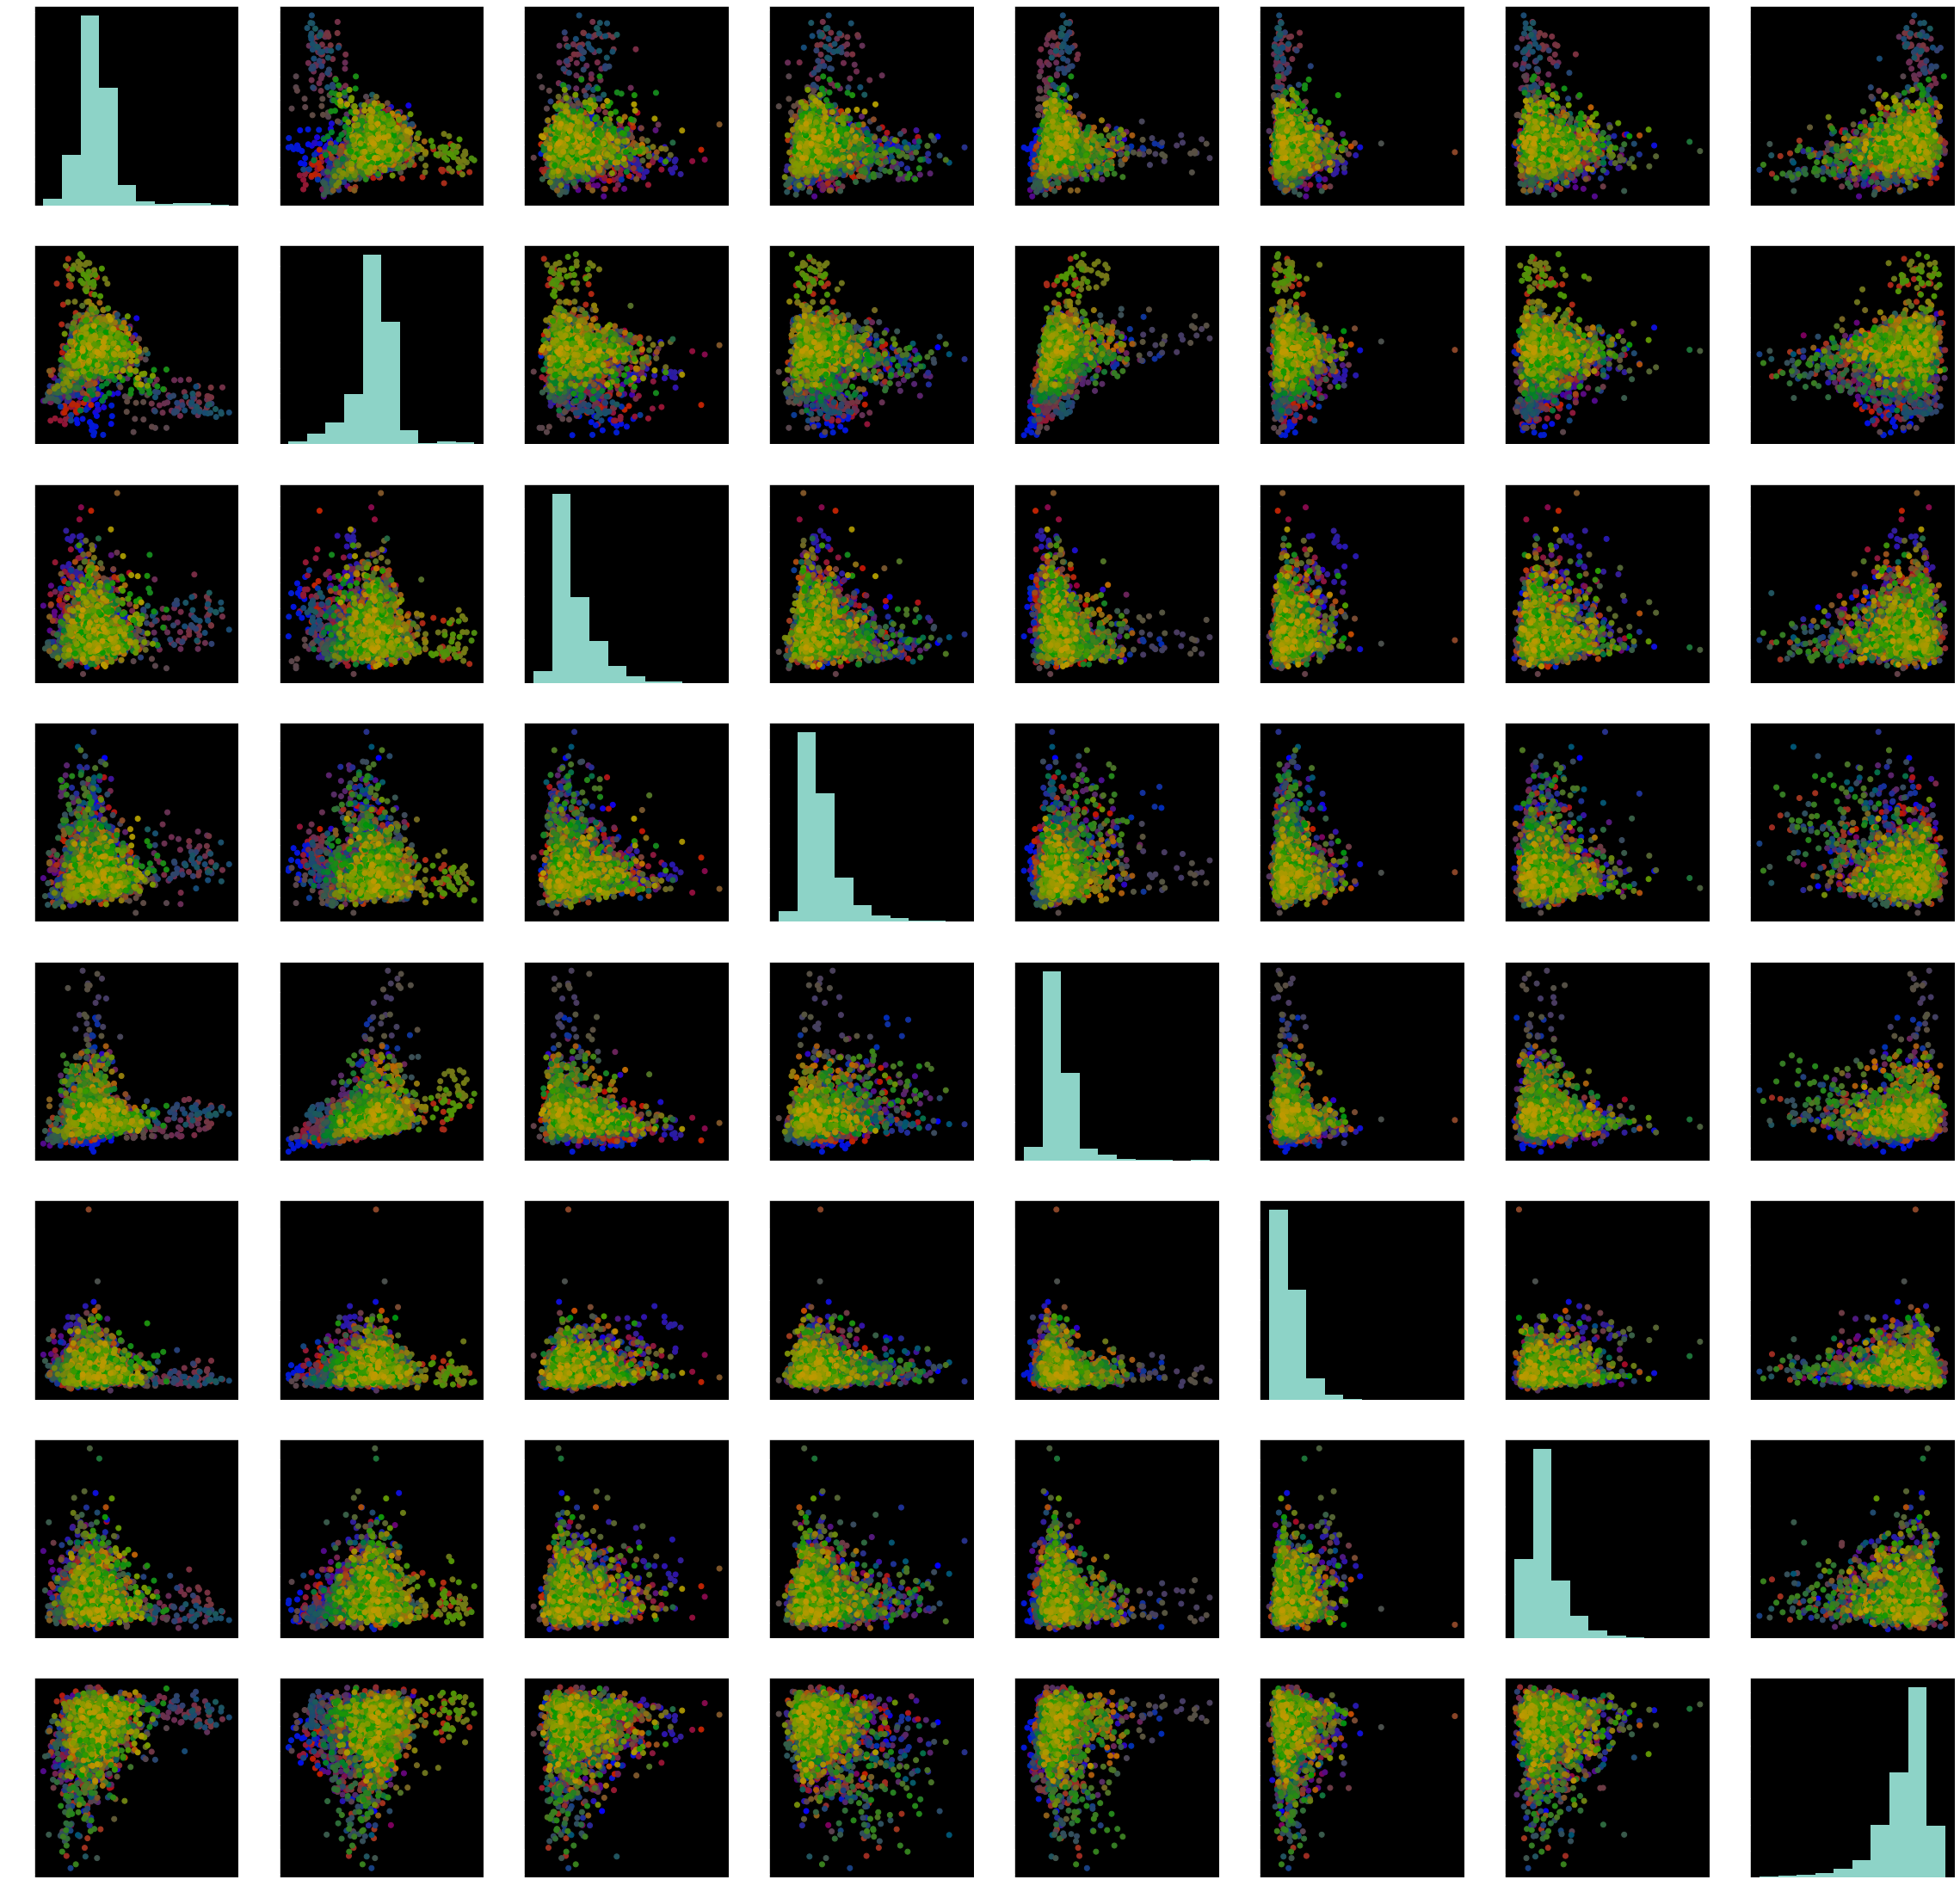

In [341]:
_,axs = plt.subplots(8,8,figsize=(40,40),)# gridspec_kw={'height_ratios':[3,1]})

for i in range(8):
    for j in range(8):
        if i == j:
            # axs[i,j].hist(pca.components_[i])
            axs[i,j].hist(pcs[:,i])
        else:
            # axs[i,j].scatter(pca.components_[i], pca.components_[j], c = c)
            axs[i,j].scatter(pcs[:,j], pcs[:,i], c = c)

    # if pcs[np.argmax(np.abs(pcs[:,cmp])),cmp] < 0:
    #     sign = -1
    # else:
    #     sign = 1

    # axs[0,cmp].imshow(sign * pca.components_[cmp].reshape(32,128), aspect=4, interpolation = 'none')
    # axs[1,cmp].plot(sign * pcs[:,cmp])



(4096, 2)


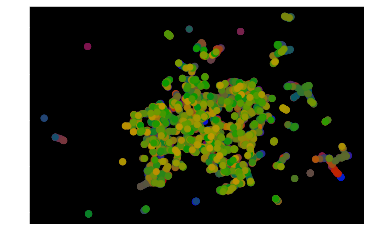

In [306]:
import umap
mod = umap.UMAP(n_neighbors=3, min_dist=.0001)
#emb = mod.fit_transform(d.T)#
emb = mod.fit_transform(pca.components_[:10,:].T)
print(emb.shape)
plt.scatter(emb[:,0], emb[:,1], c=c)

C:\Users\zfj\AppData\Local\Temp\ipykernel_45444\1307296707.py:7: RuntimeWarning: Mean of empty slice
  im = axs[0].imshow(np.nanmean(spat, axis=1), aspect=1/4, interpolation='none')
C:\Users\zfj\AppData\Local\Temp\ipykernel_45444\1307296707.py:13: RuntimeWarning: Mean of empty slice
  im2 = axs[1].imshow(np.nanmean(spat2, axis=1), aspect=1/4, interpolation='none')


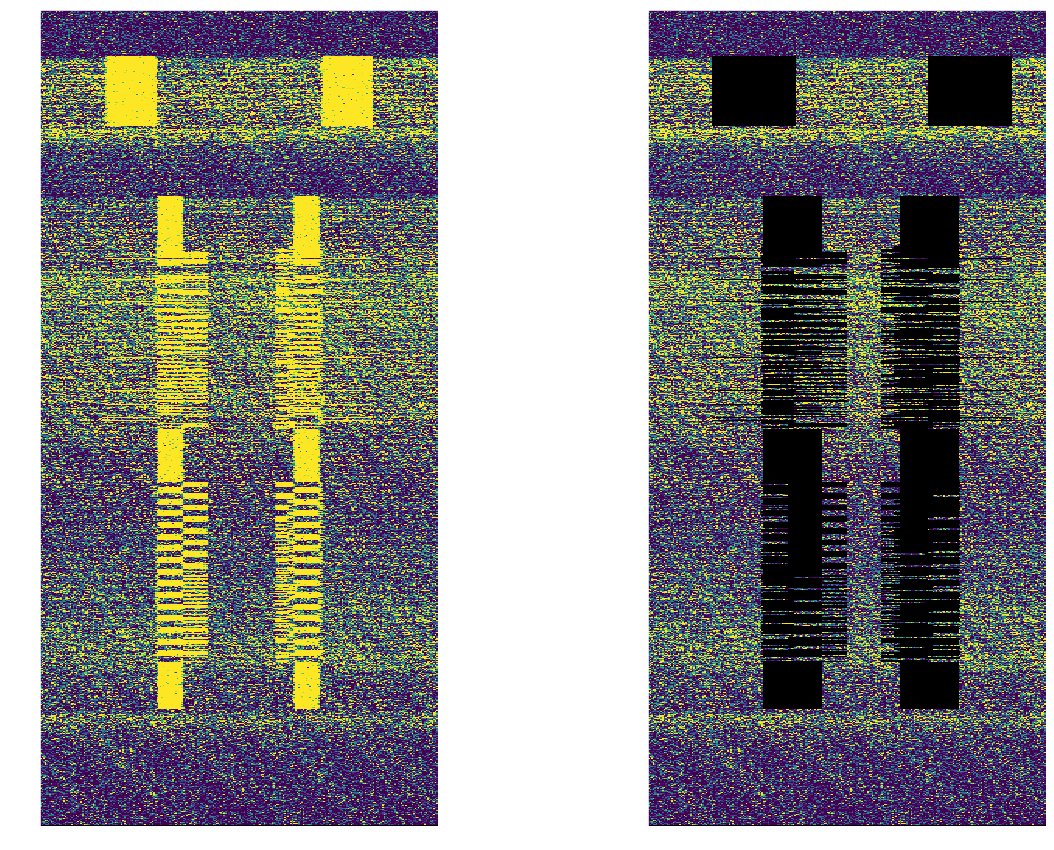

In [167]:
# plt.plot(pat)
# plt.show()

# plt.plot(spat.mean(axis=1))
# plt.plot(np.nanmean(spat,axis=1))
_,axs = plt.subplots(1,2,figsize=(20,15))
im = axs[0].imshow(np.nanmean(spat, axis=1),   aspect=1/4, interpolation='none')
# im = axs[0].imshow(spat[:,1,:], aspect=1/4, interpolation='none')
im.set_clim(0,100)


# im2 = axs[1].imshow(spat2[:,1,:], aspect=1/4, interpolation='none')
im2 = axs[1].imshow(np.nanmean(spat2, axis=1), aspect=1/4, interpolation='none')
im2.set_clim(0,100)
# plt.colorbar()
# plt.clim(0,100)

In [33]:
np.round(.125 * 255).astype(np.uint8)

32

In [36]:
anat = tif.data().reshape((-1,4,32,128))[:,0,:,:].flatten().copy()
mask = np.zeros_like(anat, dtype=bool)
lookup = np.load('artifact_lut.npy')

# flips = tmp.flips.to_numpy()[0]
# for i in range(1, len(flips)):
#     tx = tt[flips[i-1]:flips[i]]

#     ti = ((tx - tx[0])/(tx[-1]-tx[0]) * 255).astype(int)
    
#     fx = anat[flips[i-1]:flips[i]]

#     #instead, we need the frame index to figure out what the mask should be for a given frame
#     mask[flips[i-1]:flips[i]] = np.logical_and(ti>=72, ti<197)

for row, chirp in chirps.join(e.epochs[e.epochs.trial_type == b'chirp'], on='epoch_id').iterrows():
    #for now, we know the intensity is 0.125 == 1/8 aka 32 aka 00100000
    pattern = chirp_pattern(chirp.chirpIntensity, chirp.frameRate) #TODO: i want this to just be chirp.intensity...

    #this is all sorts of wrong
    # the main thing is that we need to interp the times, not the pixel indices
    for i,(a,b) in enumerate(intervals(chirp.flips)):
        if (a < chirp.stim_on) or (a >= chirp.stim_off):
            mask[a:b] = True
        else:
            frame_mask = lookup[pattern[i]]
            frame_subind = (np.arange(b-a)/(b-a)*255).astype(np.uint8) #now these range from 0 to 255
            mask[a:b] = frame_mask[frame_subind]

#at the end, we need to make sure to flip the mask so that it looks like the image...
mask = mask.reshape((-1,32,128))
mask[:,1::2,:] = np.flip(mask[:,1::2,:], axis=2)
mask = mask.flatten()


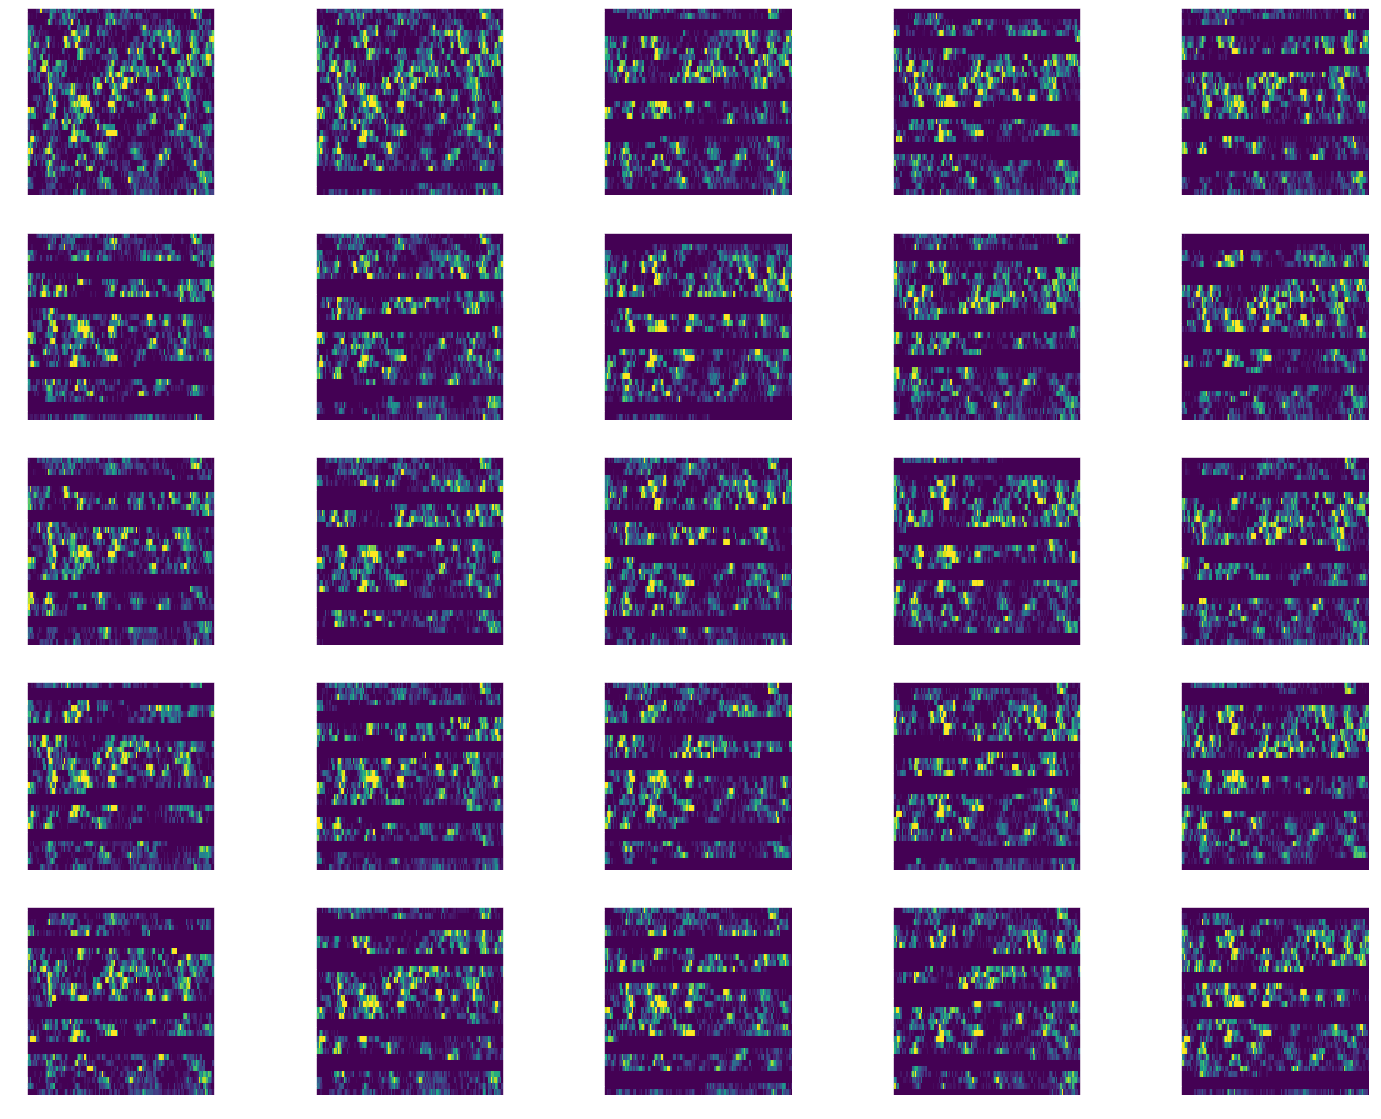

<Figure size 432x288 with 0 Axes>

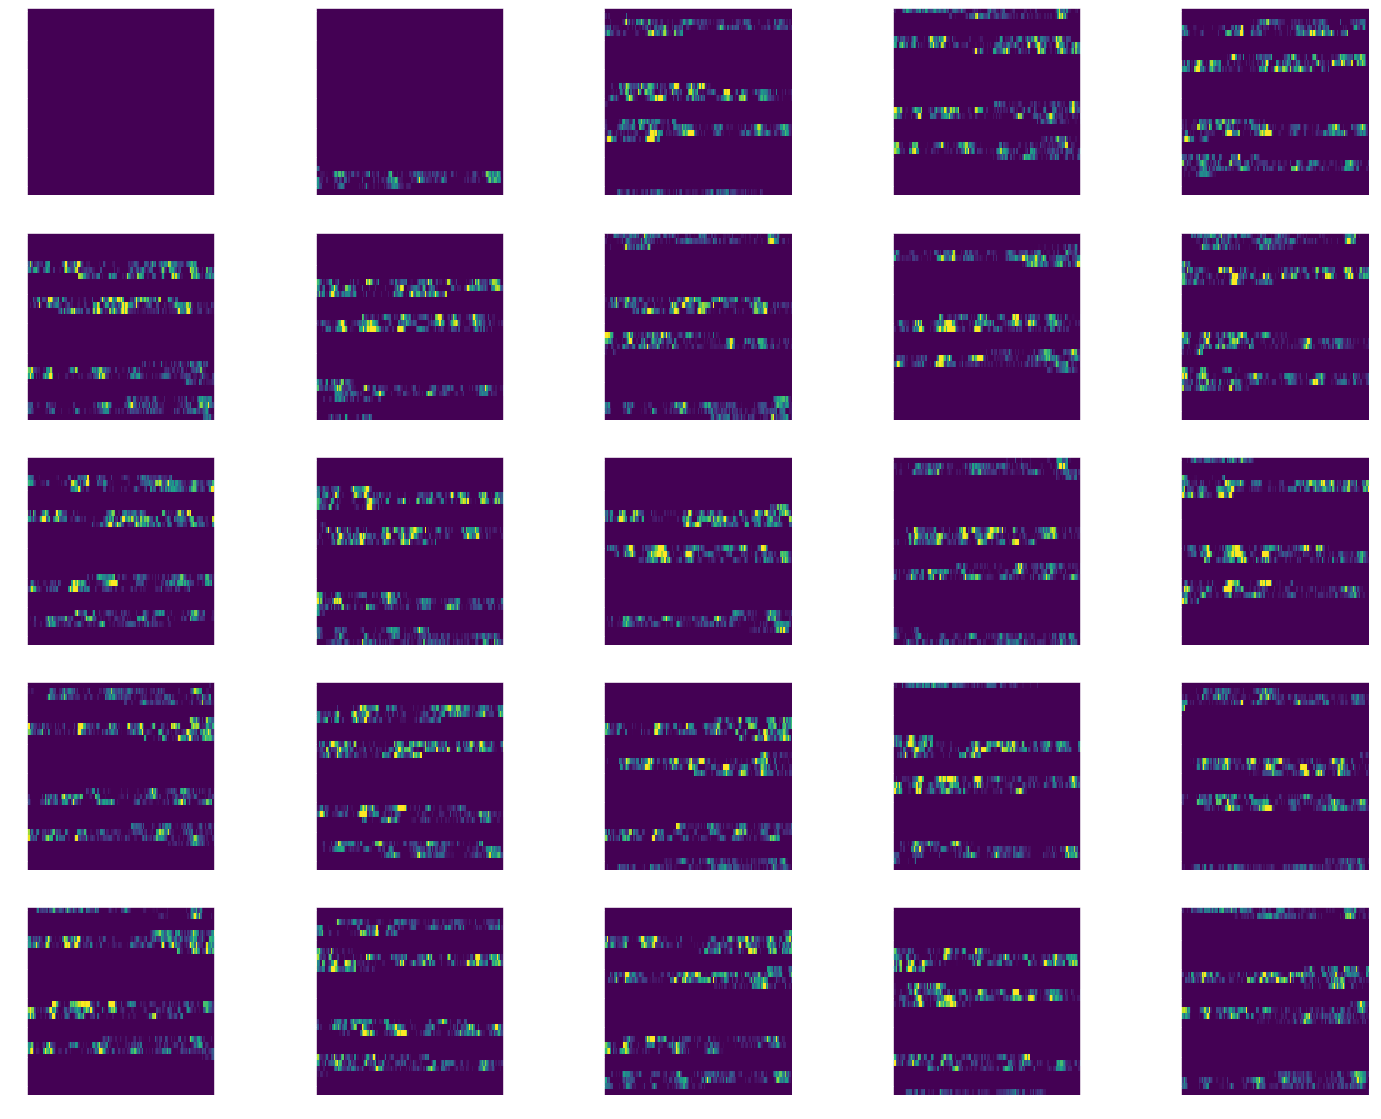

In [37]:
# plt.imshow(func[chirps.stim_on.to_numpy()[0] // (32*128) + 1], aspect=4, interpolation='none')
# plt.clim(0,1000)
# plt.colorbar()
# plt.show()

_,axs = plt.subplots(5,5,figsize=(25,20))
for i,ax in enumerate(axs.flat):
    ind = chirps.stim_on.to_numpy()[0] // (32*128) + i
    im = ax.imshow(
        anat.reshape((-1,32,128))[ind] * mask.reshape(-1,32,128)[ind]        
        , aspect=4, interpolation='none')
    im.set_clim(0,10000)

plt.figure()

_,axs = plt.subplots(5,5,figsize=(25,20))
for i,ax in enumerate(axs.flat):
    ind = chirps.stim_on.to_numpy()[0] // (32*128) + i
    im = ax.imshow(
        anat.reshape((-1,32,128))[ind] * (~mask.reshape(-1,32,128)[ind])    
        , aspect=4, interpolation='none')
    im.set_clim(0,10000)
# plt.colorbar()
# plt.show()

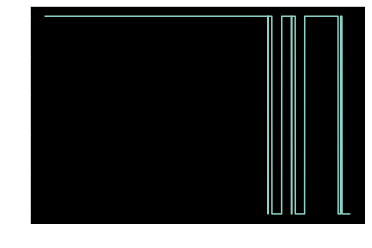

In [38]:
plt.plot(mask[chirps.stim_on.to_numpy()[0] :][:10000])

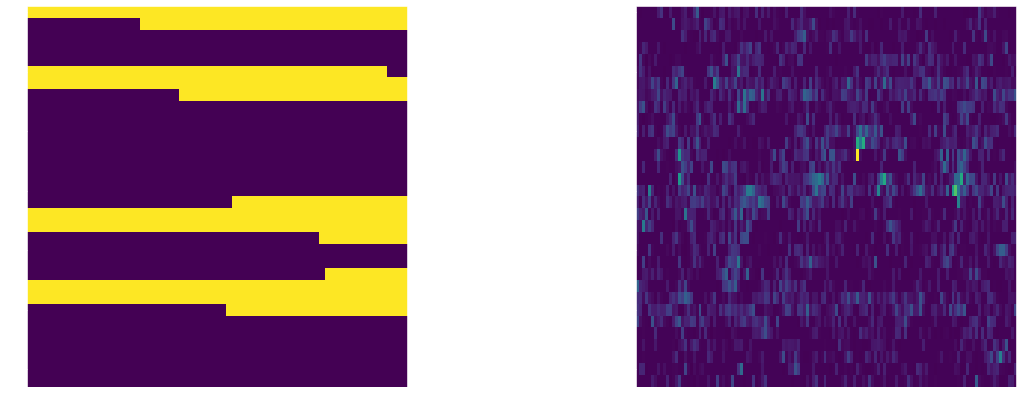

In [39]:
_,axs = plt.subplots(1,2, figsize=(20,7))

ax = axs[0]
ind = (chirps.stim_on.to_numpy()[0] // (32*128)) + 3
im = ax.imshow(
    ~mask.reshape(-1,32,128)[ind]   
    , aspect=4, interpolation='none')
# im.set_clim(0,10000)

ax = axs[1]
im = ax.imshow(
    func.reshape(-1,32,128)[ind]   
    , aspect=4, interpolation='none')


In [40]:
sl = anat.reshape((-1,32,128))[chirps.stim_on.to_numpy()[0] // (32*128): chirps.stim_on.to_numpy()[0] // (32*128)+33]
bl = mask.reshape((-1,32,128))[chirps.stim_on.to_numpy()[0] // (32*128): chirps.stim_on.to_numpy()[0] // (32*128)+33]

t = sl[:,16,64].copy()


print(bl.shape, sl.shape)
#bl is true where we want to interp

from scipy.interpolate import interp1d
t[np.argwhere(~bl[:,16,64]).flatten()] = interp1d(np.argwhere(bl[:,16,64]).flatten(), sl[:,16,64][bl[:,16,64]], fill_value='extrapolate')(np.argwhere(~bl[:,16,64]).flatten())

(33, 32, 128) (33, 32, 128)


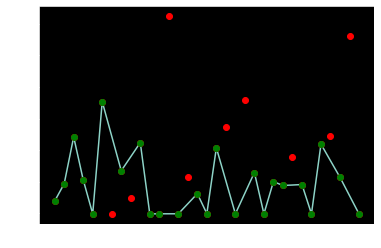

In [41]:
plt.plot(t) #the interpolated version
plt.plot(sl[:,16,64],'ro') # the original poinsts
plt.plot(np.argwhere(bl[:,16,64]), sl[:,16,64][bl[:,16,64]], 'go') #the remaining points


In [42]:
sl = func.reshape((-1,32,128))[chirps.stim_on.to_numpy()[0] // (32*128): chirps.stim_on.to_numpy()[0] // (32*128)+1000]
bl = mask.reshape((-1,32,128))[chirps.stim_on.to_numpy()[0] // (32*128): chirps.stim_on.to_numpy()[0] // (32*128)+1000]

t = sl.copy()
for i in range(32):
    for j in range(128):
        k = np.nonzero(~bl[:,i,j].flatten())[0] #points to interpolate
        l = np.nonzero(bl[:,i,j].flatten())[0] #points to keep

        t[k,i,j] = interp1d(l, sl[l,i,j], fill_value='extrapolate')(k)

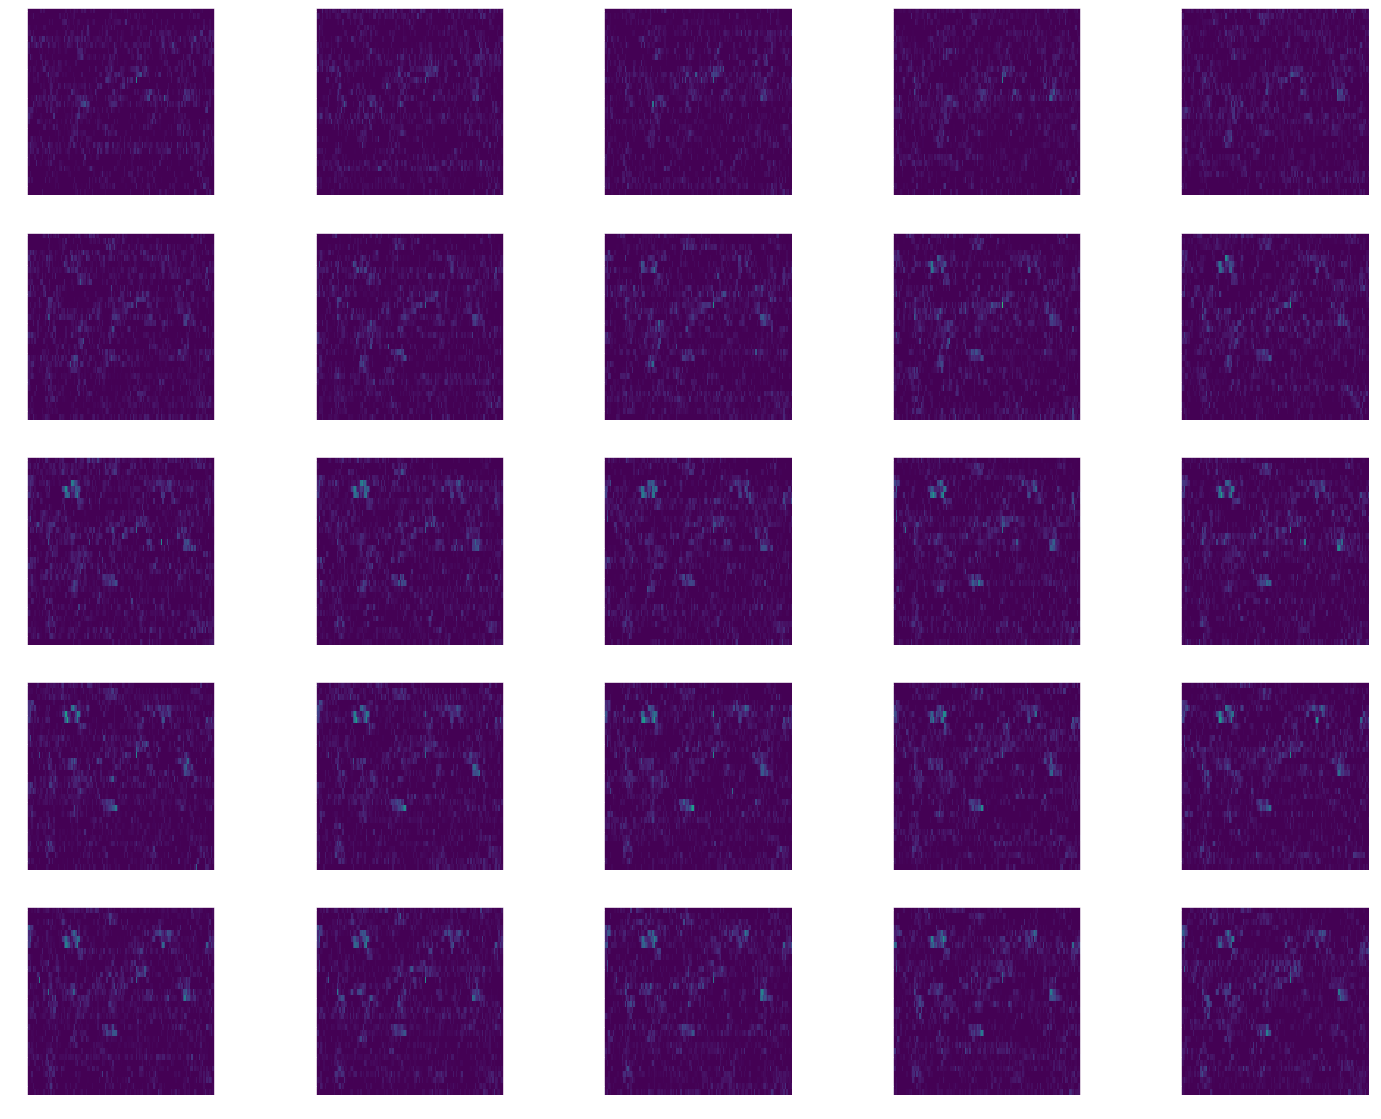

In [43]:
_,axs = plt.subplots(5,5,figsize=(25,20))
for i,ax in enumerate(axs.flat):
    im = ax.imshow(t[i], aspect=4, interpolation='none')
    # im = ax.imshow(t[i] - sl[i], aspect=4, interpolation='none')
    
    im.set_clim(0,10000)

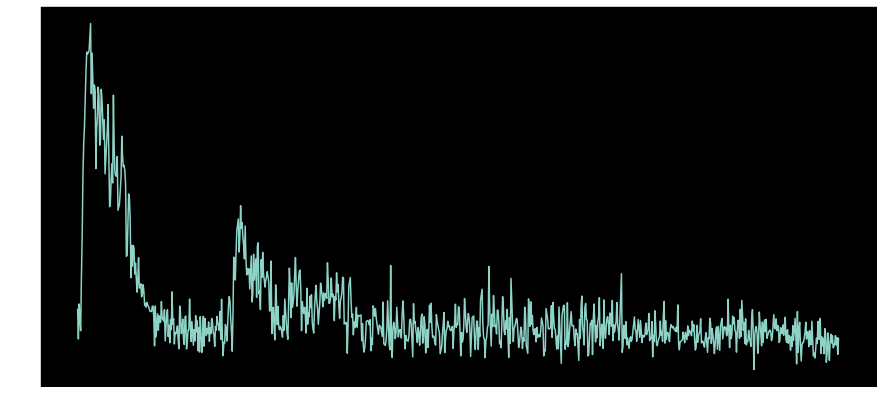

C:\Users\zfj\AppData\Local\Temp\ipykernel_10192\1062912199.py:23: RuntimeWarning: Mean of empty slice
  plt.plot(ti,np.nanmean(tt[:,4:7,25:30], axis=(-2,-1)))


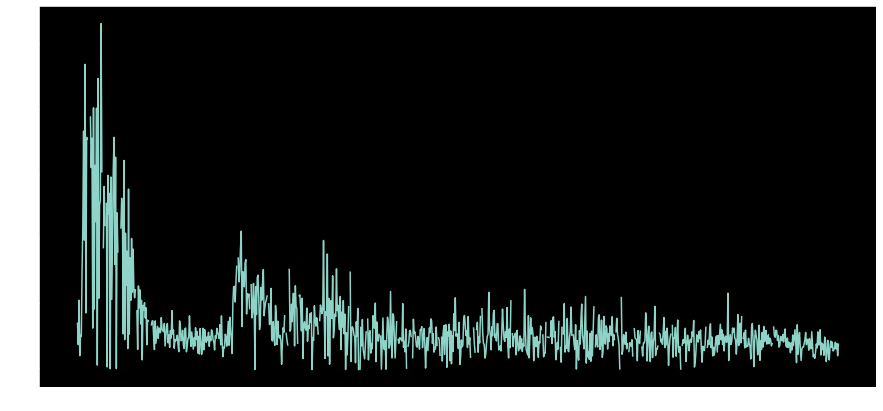

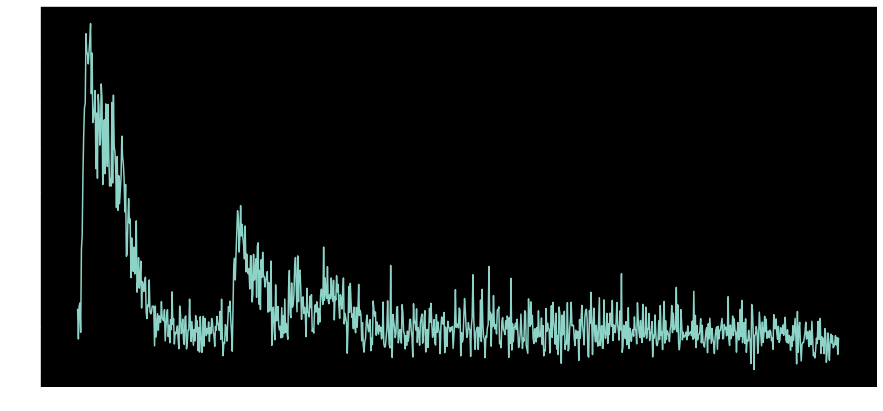

In [44]:
ti = np.arange(1000) / e.props['frame_rate']

plt.figure(figsize=(15,7))
#a few example rois from the test movie


plt.plot(ti,t[:,4:7,25:30].mean(axis=(-2,-1)))
# plt.plot(ti,t[:,10, 31:35].mean(axis=-1))
# plt.plot(ti,t[:,16,:5].mean(axis=-1))
# plt.plot(ti,t[:,23,94:103].mean(axis=-1))
plt.show()
# they look great!

plt.figure(figsize=(15,7))
tt = sl.copy().astype(np.double)
tt[~bl] = np.nan

# plt.plot(ti,np.nanmean(tt[:,10,31:35], axis=-1))
# plt.plot(ti,np.nanmean(tt[:,16,:5], axis=-1))
# plt.plot(ti,np.nanmean(tt[:,23,94:103], axis=-1))


plt.plot(ti,np.nanmean(tt[:,4:7,25:30], axis=(-2,-1)))
# plt.plot(ti,np.nanmean(tt[:,16,:5], axis=-1))
# plt.plot(ti,np.nanmean(tt[:,23,94:103], axis=-1))


plt.figure(figsize=(15,7))
plt.plot(ti,sl[:,4:7,25:30].mean(axis=(-2,-1)))


In [229]:
#For each video
#   For each pixel
#       Calculate whether to mask the pixel based on the intensity
#       Interpolate masked pixels using linear interpolation
#       Run motion detection


# t.reshape((-1,32*128)).shape

# l,v = np.linalg.eig(np.cov(t.reshape((-1,32*128)).T))

from sklearn.decomposition import PCA #MiniBatchSparsePCA as PCA # SparsePCA as PCA

d = t.reshape((-1, 32*128))
d = d - d.mean(axis=0)
d = d / d.std(axis=0)


pca = PCA(n_components=100)#, n_jobs=8, alpha=5, batch_size=20)
pcs = pca.fit_transform(d)


In [230]:
np.count_nonzero([np.count_nonzero(pca.components_[cmp]) for cmp in range(pcs.shape[1])])
print([np.count_nonzero(pca.components_[cmp]) for cmp in range(pcs.shape[1])])



[4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096, 4096]


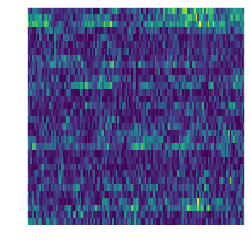

4096


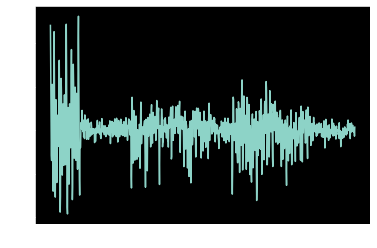

In [241]:
# plt.plot(pcs[:,1])
# pcs.shape
# pca.sco

cmp = 7
if pcs[np.argmax(np.abs(pcs[:,cmp])),cmp] < 0:
    sign = -1
else:
    sign = 1

plt.imshow(np.abs(pca.components_[cmp].reshape(32,128)), aspect=4, interpolation = 'none')
plt.show()
plt.plot(sign * pcs[:,cmp])


print(np.count_nonzero(pca.components_[cmp]))

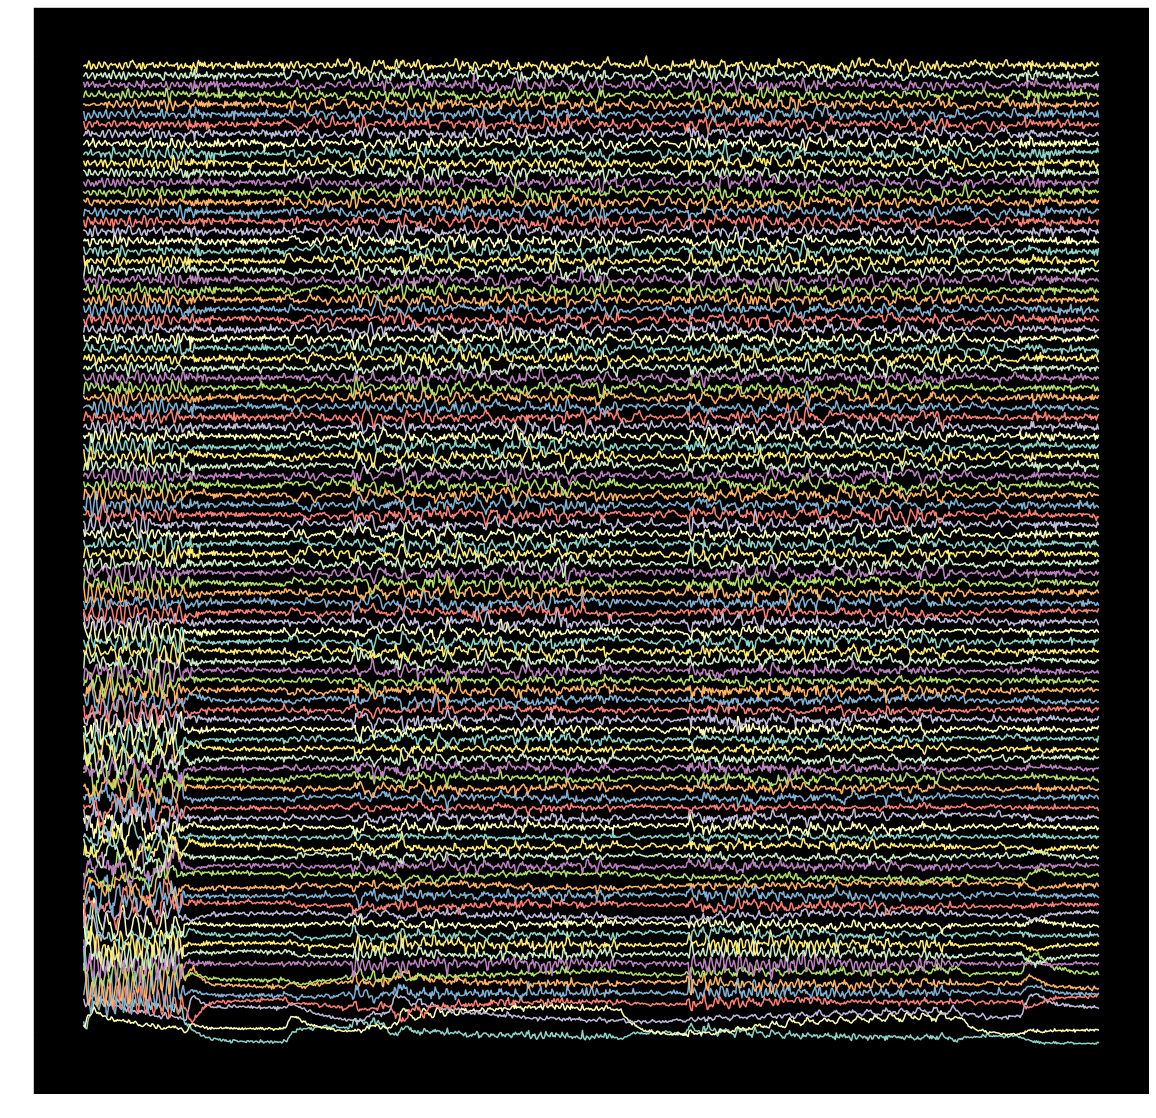

In [232]:
plt.figure(figsize=(20,20))
plt.plot(pcs/10 + np.arange(100).reshape((-1,100)))
plt.show()